In [4]:
import math
import random
import numpy as np
import pandas as pd
import nltk
import pyodbc
import warnings 
warnings.filterwarnings('ignore')

from libraries import utils_preprocess as upp, utils_ngram as ung, utils_perplexity as up, utils_suggestions as suggest

In [5]:
conx_string = "DRIVER={ODBC Driver 17 for SQL Server}; SERVER=APCKRMPTMD01PV,41433; Database=Namlos; UID=Namlos_user; PWD=M@!!eL@498#;"
conx = pyodbc.connect(conx_string)
query = '''SELECT [Activity]
      ,[KbPlant]
      ,[Issue]
      ,[kbArea] as Area
      ,[Scope]
      ,[CreatedDate] as Date
  FROM [Namlos].[dbo].[KB_View_Issue_PowerBI]'''


df = pd.read_sql(query, conx)
print(df.shape)
df.head()

(12916, 6)


,Activity,KbPlant,Issue,Area,Scope,Date
0,Kerja-Bersama,West,PPE diletakkan diluar kotak PPE. Ada barang2 l...,VUM,5S,2022-09-05
1,Kerja-Bersama,East,tali tas rawan nyangkut/kepleset,Final_Assembly,Safety,2022-09-05
2,Kerja-Bersama,East,tray terlalu dekat dengan paha operator,Final_Assembly,Safety,2022-09-05
3,Kerja-Bersama,East,Alat elektronik dekat kaki operator,Final_Assembly,Safety,2022-09-05
4,Kerja-Bersama,East,Alat elektronik dekat kaki,Final_Assembly,Safety,2022-09-05


In [7]:
df['Area'] = df['Area'].replace('','DS_Gemba')
df['Area'].value_counts()

Area
Final_Assembly    2934
PIM               1180
Rotocast           691
PA_MBD             591
Diecast            556
Barbell            553
ANP                498
OMC                480
ESP                422
Tampo              415
VUM                399
Auto Rooting       274
BBD                256
Spray              245
DIJ_MBD            217
Tampo_MBD          215
Die Cut            201
Sewing             107
DS Gemba            74
PA_MDC              63
Tampo_MDC           24
Name: count, dtype: int64

<Axes: xlabel='Scope'>

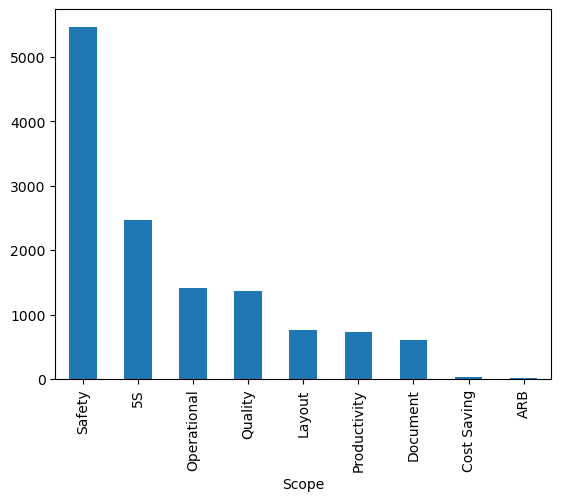

In [9]:
df = df[df['Scope'].ne('null')]
df = df[df['Scope'].ne('-')]
df = df[df['Scope'].str.strip().ne('')]
df['Scope'] = df['Scope'].replace('Documents', 'Document')
df['Scope'].value_counts().plot(kind ='bar')

In [14]:
df.dropna(subset=['Issue'], inplace=True)

In [15]:
data = ' '.join(df['Issue'])

In [16]:
tokenized_data = upp.get_tokenized_data(data)
random.seed(87)
random.shuffle(tokenized_data)

train_size = int(len(tokenized_data) * 0.8)
train_data = tokenized_data[0:train_size]
test_data = tokenized_data[train_size:]

In [17]:
print("{} data are split into {} train and {} test set".format(len(tokenized_data), len(train_data), len(test_data)), end='\n\n')
print(f"First training sample: {train_data[0]}", end='\n\n')
print(f"First test sample : {test_data[0]}", end='\n\n')

99 data are split into 79 train and 20 test set

First training sample: ['rc22', 'dekat', 'pintu', 'emergency', 'pendinginnya', 'kurang', ',', 'masih', 'menggunakan', 'selang', 'angin']

First test sample : ['yellow', 'line', 'derack', 'terkelupas']



In [18]:
train_data, test_data, vocab = upp.preprocess_data(train_data, test_data, count_threshold=2)
print(f"First preprocessed training sample : {train_data[0]}", end='\n\n')
print(f"First preprocessed test sample : {test_data[0]}", end='\n\n')
print(f"First 10 vocabulary : {vocab[0:10]}", end='\n\n')
print("Size of vocabulary:", len(vocab))

First preprocessed training sample : ['rc22', 'dekat', 'pintu', 'emergency', '<unk>', 'kurang', ',', 'masih', 'menggunakan', 'selang', 'angin']

First preprocessed test sample : ['yellow', 'line', 'derack', 'terkelupas']

First 10 vocabulary : ['rc22', 'dekat', 'pintu', 'emergency', 'kurang', ',', 'masih', 'menggunakan', 'selang', 'angin']

Size of vocabulary: 2979


In [19]:

n_gram_counts_list = []
for n in range(1, 6):
    print("Computing n-gram counts with n =", n, "...")
    n_model_counts = ung.count_n_grams(train_data, n)
    n_gram_counts_list.append(n_model_counts)

Computing n-gram counts with n = 1 ...
Computing n-gram counts with n = 2 ...
Computing n-gram counts with n = 3 ...
Computing n-gram counts with n = 4 ...
Computing n-gram counts with n = 5 ...


In [20]:
previous_tokens = ["yellow", "line"]
suggest_words = suggest.get_suggestions(previous_tokens, n_gram_counts_list, vocab, k=1.0)

print(f"The previous words are {previous_tokens}, the suggestions are:")
display(suggest_words)

The previous words are ['yellow', 'line'], the suggestions are:


[('<unk>', 0.009738283627510651),
 ('terkelupas', 0.0035188739603326936),
 ('rc22', 0.0003354579000335458),
 ('rc22', 0.0003354579000335458)]

In [21]:
previous_tokens = ["kabel"]
suggest_words = suggest.get_suggestions(previous_tokens, n_gram_counts_list, vocab, k=1.0)

print(f"The previous words are {previous_tokens}, the suggestions are:")
display(suggest_words)

The previous words are ['kabel'], the suggestions are:


[('menjuntai', 0.01455108359133127),
 ('rc22', 0.0003354579000335458),
 ('rc22', 0.0003354579000335458),
 ('rc22', 0.0003354579000335458)]

In [25]:
previous_tokens = ["cover", "mesin", "tidak"]
suggest_words = suggest.get_suggestions(previous_tokens, n_gram_counts_list, vocab, k=1.0)

print(f"The previous words are {previous_tokens}, the suggestions are:")
display(suggest_words)

The previous words are ['cover', 'mesin', 'tidak'], the suggestions are:


[('ada', 0.11634404310516863),
 ('ada', 0.0046022353714661405),
 ('ada', 0.0016722408026755853),
 ('rc22', 0.0003354579000335458)]

In [28]:
previous_tokens = ["area", "neckline", "tidak"]
suggest_words = suggest.get_suggestions(previous_tokens, n_gram_counts_list, vocab, k=1.0)

print(f"The previous words are {previous_tokens}, the suggestions are:")
display(suggest_words)

The previous words are ['area', 'neckline', 'tidak'], the suggestions are:


[('ada', 0.11634404310516863),
 ('konsisten', 0.0006706908115358819),
 ('konsisten', 0.0006706908115358819),
 ('rc22', 0.0003354579000335458)]

In [29]:
previous_tokens = ["black", "spot"]
suggest_words = suggest.get_suggestions(previous_tokens, n_gram_counts_list, vocab, k=1.0)

print(f"The previous words are {previous_tokens}, the suggestions are:")
display(suggest_words)

The previous words are ['black', 'spot'], the suggestions are:


[('welding', 0.010557571758495546),
 ('dan', 0.0013351134846461949),
 ('rc22', 0.0003354579000335458),
 ('rc22', 0.0003354579000335458)]